In [ ]:
# loading necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [ ]:
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.abs(np.sum(y_pred)) * 100

## Data exploration

In [ ]:
df = pd.read_csv(r'data_regression_for_task.csv')

In [ ]:
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.0,0.0
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.0,0.0
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.0,0.0
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.0,0.0
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.0,0.0


In [ ]:
# from the first look, there are 6 categorical columns (YEAR, MONTH, CONTRAGENT, ARTICLE_CODE, ARTICLE_NAME, ARTICLE_GROUP)
# and 4 numerical columns (SALES, STORE_SALES)

In [ ]:
# How many rows?
df.shape

(128355, 8)

In [ ]:
# look into datatypes of features
# indeed 4 - object (string or nan)
# 4 - numerical (int or float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [ ]:
# let us calculate nan values in a dataset
df.isna().sum()

YEAR              0
MONTH             0
CONTRAGENT       24
ARTICLE_CODE      0
ARTICLE_NAME      0
ARTICLE_GROUP     1
SALES             0
STORE_SALES       0
dtype: int64

In [ ]:
# 25 rows is insignificant comparing to 128355,
# so we can drop them
df = df.dropna();
df.isna().sum()

YEAR             0
MONTH            0
CONTRAGENT       0
ARTICLE_CODE     0
ARTICLE_NAME     0
ARTICLE_GROUP    0
SALES            0
STORE_SALES      0
dtype: int64

In [ ]:
# as you can see, there are negative values in SALES and STORE_SALES that need to be removed
# moreover, max values are much higher than Q75 for same features

# There are only 2 years: 2017 and 2018
df.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,128330.000000,128330.000000,1.283300e+05,128330.000000
mean,2017.206024,7.079225,6.564316e+03,22.681679
std,0.404449,3.645799,2.892762e+04,239.574553
min,2017.000000,1.000000,-6.490000e+03,-4996.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,3.300000e+02,1.000000
75%,2017.000000,10.000000,3.250000e+03,4.000000
max,2018.000000,12.000000,1.616600e+06,16271.750000


In [ ]:
# There are 337 rows, where SALES or STORE_SALES are negative
# we can remove them as well
df[(df['SALES'] < 0) | (df['STORE_SALES'] < 0)].value_counts().sum()

337

In [ ]:
df.drop(df[df['SALES'] < 0].index, inplace=True)
df.drop(df[df['STORE_SALES'] < 0].index, inplace=True)

In [ ]:
# now the mean is fixed
df.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,127993.000000,127993.000000,1.279930e+05,127993.000000
mean,2017.205972,7.078426,6.578369e+03,23.097518
std,0.404412,3.645356,2.896192e+04,237.233897
min,2017.000000,1.000000,0.000000e+00,0.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,3.300000e+02,1.000000
75%,2017.000000,10.000000,3.260000e+03,4.000000
max,2018.000000,12.000000,1.616600e+06,16271.750000


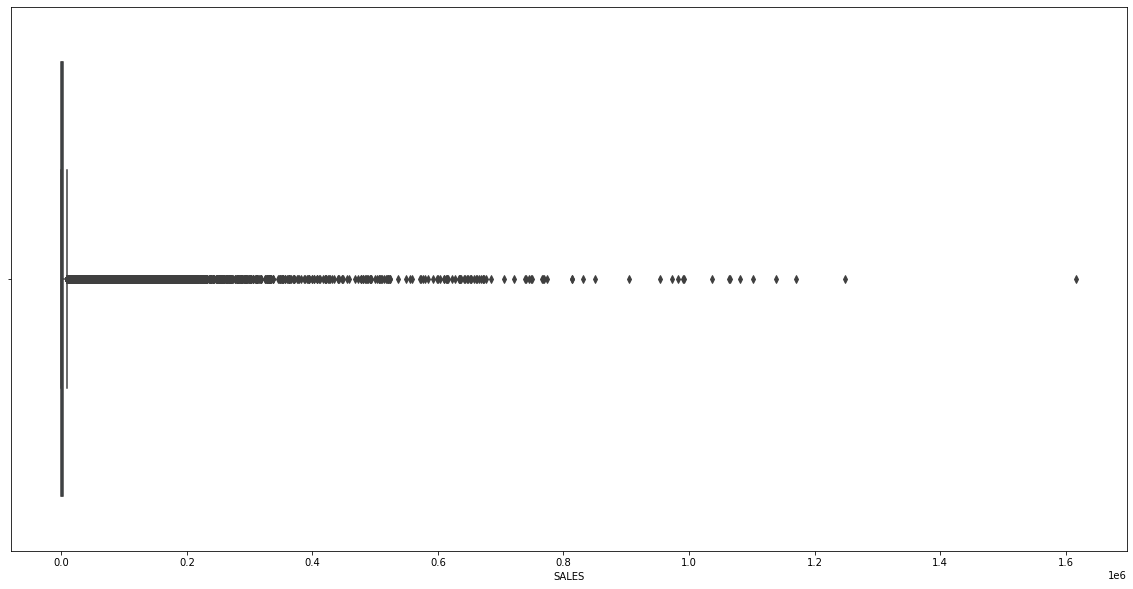

In [ ]:
# Let us look into SALES distibution
sns.boxplot(x = 'SALES', data = df)
# The distibution is quite bad

In [ ]:
# from this I can assume that 2 points (or even 1) from the SALES (>1.2*1e6) can be outliers
# thus, I would remove them from the dataset
df = df.drop(df[df['SALES'] >= 1.2*1e6].index)

In [ ]:
# Let us look into total SALES for each month
df.groupby('MONTH', as_index=False).agg({'SALES': 'sum'})

,MONTH,SALES
0,1,75783950.0
1,2,77646180.0
2,4,0.0
3,5,94665740.0
4,6,96105960.0
5,8,87105460.0
6,9,90442820.0
7,10,89167800.0
8,11,98307000.0
9,12,129894710.0


In [ ]:
# No sales in April + We confirmed that we would not predict for april. Thus, data can be removed (maybe store was closed)
df[df['MONTH']==4]['YEAR'].value_counts() 

2017    5195
Name: YEAR, dtype: int64

In [ ]:
df = df.drop(df[df['MONTH'] == 4].index)

In [ ]:
# function that would add month number up to 2 digits (1 -> 01)
def transformer(x):
  x = str(x)
  if len(x) !=2:
    x = "0" + x
  return x

In [ ]:
# I want to look into sales graph for each product type
df['YEAR_MONTH']= df['YEAR'].apply(str) + df['MONTH'].apply(transformer)

In [ ]:
# look into every article that we have
df['ARTICLE_GROUP'].unique()

array(['WINE', 'REF', 'BEER', 'KEGS', 'LIQUOR', 'STR_SUPPLIES',
       'NON-ALCOHOL'], dtype=object)

In [ ]:
sales = df.groupby(['YEAR_MONTH', 'ARTICLE_GROUP'], as_index=False).agg({'SALES': 'sum'}).sort_values('YEAR_MONTH')

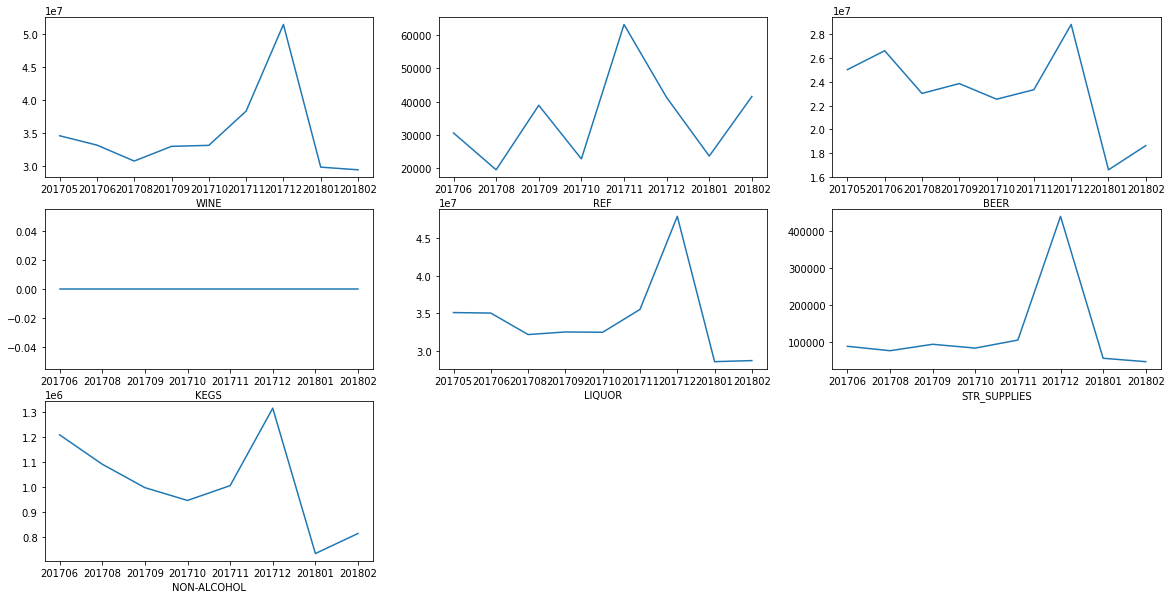

In [ ]:
for i, column in enumerate(df['ARTICLE_GROUP'].unique(), start=1):
    plt.subplot(3, 3, i)
    sale = sales[sales['ARTICLE_GROUP']==column].sort_values('YEAR_MONTH')
    plt.plot(sale['YEAR_MONTH'], sale['SALES'])
    plt.xlabel(column)

In [ ]:
# As you can see from the graphs - no sales for KEGS at all (perhaps, we can remove this data as well)
df = df.drop(df[df['ARTICLE_GROUP'] == 'KEGS'].index)

# Actually, I wanted to compare trends of year+month pairs for each year, but 2017 and 2018 do not overlap in months (but they provide order)

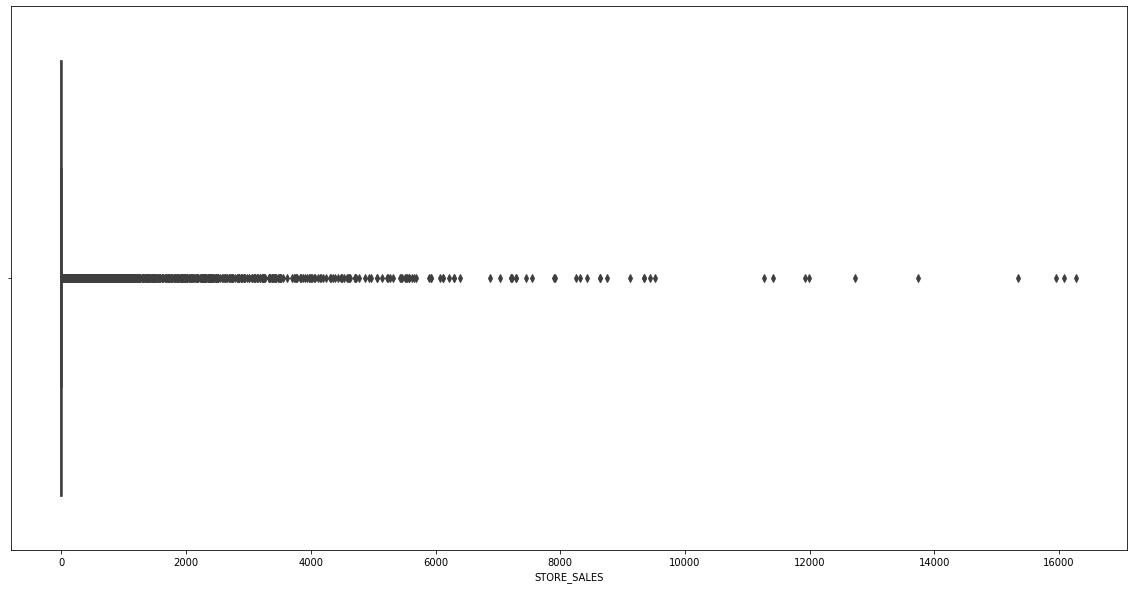

In [ ]:
# Let us look into STORE_SALES
sns.boxplot(x = 'STORE_SALES', data = df)
# almost same 'not good' distribution
# We can remove 2 points, which seem to be separated from the rest of th group
df = df.drop(df[df['STORE_SALES'] >= 12000].index)

In [ ]:
df.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,119197.000000,119197.000000,1.191970e+05,119197.000000
mean,2017.214158,7.201977,7.005215e+03,23.564710
std,0.410239,3.663696,2.879963e+04,217.622059
min,2017.000000,1.000000,0.000000e+00,0.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,4.800000e+02,1.000000
75%,2017.000000,10.000000,3.890000e+03,4.000000
max,2018.000000,12.000000,1.170000e+06,11995.000000


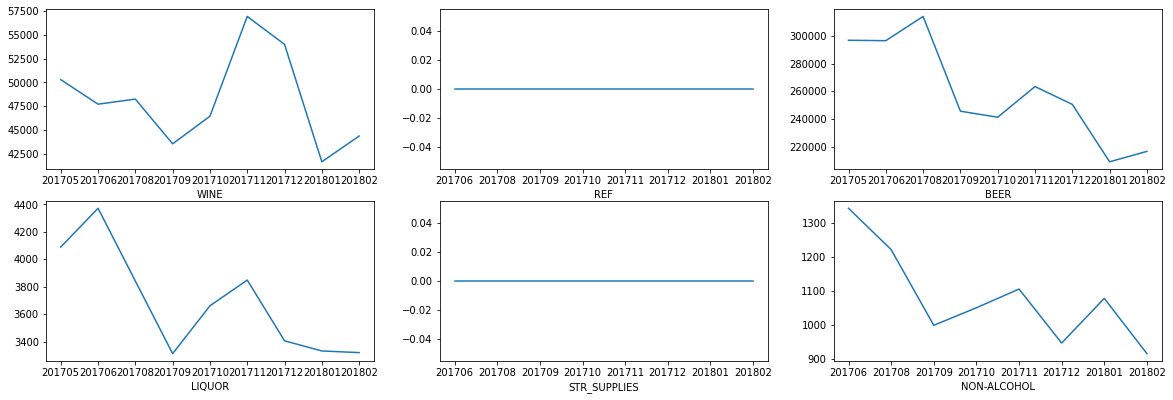

In [ ]:
# we can look at the same graphs for store_sales, yet as I suppose, store_Sales gives information only about 
# one store, not the whole tendency
# because, for example in the store, no REF or STR_SUPPLIERS were sold
sales = df.groupby(['YEAR_MONTH', 'ARTICLE_GROUP'], as_index=False).agg({'STORE_SALES': 'sum'}).sort_values('YEAR_MONTH')
for i, column in enumerate(df['ARTICLE_GROUP'].unique(), start=1):
    plt.subplot(3, 3, i)
    sale = sales[sales['ARTICLE_GROUP']==column].sort_values('YEAR_MONTH')
    plt.plot(sale['YEAR_MONTH'], sale['STORE_SALES'])
    plt.xlabel(column)

In [ ]:
# My main question about this dataset:
# Does the store_sales mean the total sales for a particular article?

# 1) In this case, it is intuitive that SALES has to be greater than STORE_SALES since
# SALES is a combination of sales of multiple stores. In this case, we would have to remove around
# 42 thousand of entries from consideration. 

# 2) Another scenario: we consider that STORE_SALES is the total for ALL products sold,
# then it is intuitive that SALES < STORE_SALES should hold.

# I want to consider case 1 and case, when we leave dataset as it is
print("SALES > STORE_SALES:", df[(df['SALES'] > df['STORE_SALES'])].value_counts().sum())
print("SALES < STORE_SALES:", df[(df['SALES'] < df['STORE_SALES'])].value_counts().sum())

SALES > STORE_SALES: 79022
SALES < STORE_SALES: 38482


## Feature selection

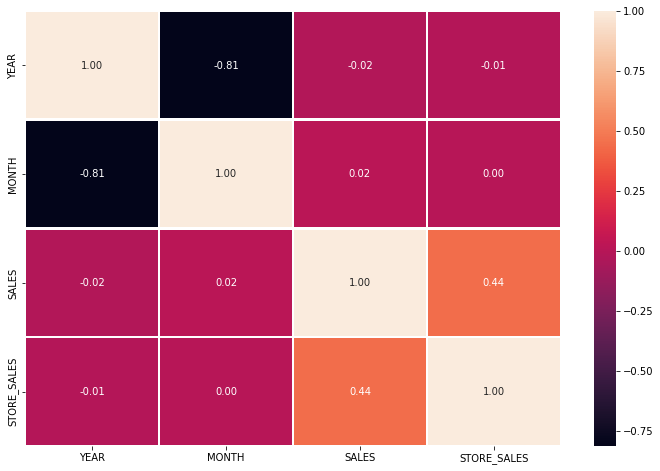

In [ ]:
# confusion matrix of some features :)

# MONTH and YEAR look highly correlated, but again, they are categorical, so we will test with chi2.
corr = df.corr()
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax)
plt.show()

# STORE_SALES and SALES look correlated (good!)
# Due to range of STORE_SALES & SALES correlation with MONTH and YEAR is 0
# Yet both MONTH and YEAR are categorical - need to apply another test.

In [ ]:
import scipy.stats as ss
# actually, no correlation btw year and month, which was misinterpreted by confusion matrix
# H0 - features are not correlated
ss.chi2_contingency(pd.crosstab(df['YEAR'], df['MONTH']))[1]

0.0

In [ ]:
# correlation for categorical + numerical values
# is better calculated with eta value (image below)

def correlation_ratio(categories, measurements):
    # getting number of values and creating a grid
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)

    for i in range(0,cat_num):
        cat_measures = measurements.iloc[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    # calculating y avg, numerator and denominator
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        # getting a squre root
        eta = np.sqrt(numerator/denominator)
    return eta

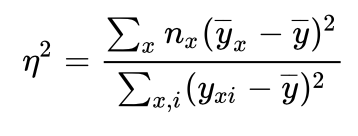

In [ ]:
print('YEAR vs. SALES:',correlation_ratio(df['YEAR'], df['SALES'].apply(lambda x: np.log(x+1))))
print('MONTH vs. SALES:',correlation_ratio(df['MONTH'], df['SALES'].apply(lambda x: np.log(x+1))))
print('YEAR_MONTH vs. SALES:',correlation_ratio(df['YEAR_MONTH'], df['SALES'].apply(lambda x: np.log(x+1))))
# Mostly only month is important for sales values (which is quite logical)

YEAR vs. SALES: 0.0062506427180244375
MONTH vs. SALES: 0.045907473559706015
YEAR_MONTH vs. SALES: 0.045907473559706015


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


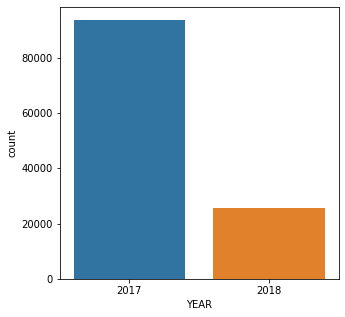

In [ ]:
# plus YEAR can be questioned, as 2017 has a lot more entries (whole year) vs 2018
plt.figure(figsize=(5,5))
sns.countplot(df['YEAR'])
# Yet year feature could help the model to differenciate the ordering of months (as I said earlier)

In [ ]:
# mostly, wine is sold, followed by liquor (can one hot encode them)
df['ARTICLE_GROUP'].value_counts()

WINE            76089
LIQUOR          26634
BEER            15768
NON-ALCOHOL       576
STR_SUPPLIES       96
REF                34
Name: ARTICLE_GROUP, dtype: int64

In [ ]:
# there are 329 suppliers as well for each product (we can one-hot encode still)
df['CONTRAGENT'].nunique()

329

In [ ]:
# 2 most questionable columns are the ARTICLE_CODE and ARTICLE_NAME
# they both reflect same information, so we could have kept only one of them
# Yet, there are more than 15 thousand articles for wine itself, so no use from articles (impossible for me to encode)
df.groupby('ARTICLE_GROUP', as_index=False).agg({'ARTICLE_CODE': pd.Series.nunique})\
  .rename(columns={'ARTICLE_CODE': 'UNIQUE_ARTICLES'}).sort_values('UNIQUE_ARTICLES', ascending=False)

,ARTICLE_GROUP,UNIQUE_ARTICLES
5,WINE,15281
1,LIQUOR,3563
0,BEER,3216
2,NON-ALCOHOL,87
4,STR_SUPPLIES,15
3,REF,6


In [ ]:
# I wanted to see, maybe there can be defined a pair CONTRAGENT + ATRICLE_CODE, but still there are 
# 1748 articles for A VINTNERS SELECTIONS
df.groupby(['CONTRAGENT', 'ARTICLE_GROUP'], as_index=False).agg({'ARTICLE_CODE': pd.Series.nunique})\
  .rename(columns={'ARTICLE_CODE': 'UNIQUE_ARTICLES'}).sort_values('UNIQUE_ARTICLES', ascending=False)

,CONTRAGENT,ARTICLE_GROUP,UNIQUE_ARTICLES
7,A VINTNERS SELECTIONS,WINE,1748
321,REPUBLIC NATIONAL DISTRIBUTING CO,WINE,1571
231,LEGENDS LTD,BEER,1027
261,MONSIEUR TOUTON SELECTION,WINE,1015
39,BACCHUS IMPORTERS LTD,WINE,688
...,...,...,...
1,A HARDY USA LTD,LIQUOR,1
233,LEGENDS LTD,NON-ALCOHOL,1
377,SUTTER HOME WINERY INC,LIQUOR,1
375,SUGARLOAF MOUNTAIN VINEYARD LLC,WINE,1


In [ ]:
# For the ARTICLE_NAME I wanted to use word frequency approach, where there is a pool of words
# and each row has identifier of occurences.
# But in case of alcohol names there is no trend and all of them a quite differnt (even language),
# this approach works with small sentences or at most song names (espesially, pop songs)

In [ ]:
# Anyway, I wanted to see how many type of products each CONTRAGENT produces and saw that a lot of them
# have multiple products

# I suppose these 2 features (CONTRAGENT + ARTICLE_GROUP) would be a good identifier still. 
# For example, it is pretty common that if a brand's wine is popular, most of its articles are same 
# (but this is my assumption)
df.groupby(['CONTRAGENT'], as_index=False).agg({'ARTICLE_GROUP': pd.Series.nunique})\
  .rename(columns={'ARTICLE_GROUP': 'UNIQUE_GROUPS'}).sort_values('UNIQUE_GROUPS', ascending=False)

,CONTRAGENT,UNIQUE_GROUPS
26,BACCHUS IMPORTERS LTD,4
225,RELIABLE CHURCHILL LLLP,4
3,A VINTNERS SELECTIONS,4
227,REPUBLIC NATIONAL DISTRIBUTING CO,4
78,DIAGEO NORTH AMERICA INC,4
...,...,...
130,GRAND ENCLOS DU CHATEAU DE CERONS,1
132,GRAPES OF SPAIN INC,1
133,GROTH VINEYARDS & WINERY,1
134,HAMCO DC,1


In [ ]:
# removing ARTICLE_NAME and ARTICLE_CODE from consideration
df = df.drop(columns=['ARTICLE_NAME', 'ARTICLE_CODE'])

## Data preprocessing

In [ ]:
from sklearn.preprocessing import FunctionTransformer
# Since MONTH is a cyclical value, we cannot just encode it with ohe.
# We will use sine/cosine transformation. 
def sin_transformer(period):
	return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
	return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

df["MONTH_SIN"] = sin_transformer(12).fit_transform(df["MONTH"])
df["MONTH_COS"] = cos_transformer(12).fit_transform(df["MONTH"])

In [ ]:
df.head()

,YEAR,MONTH,CONTRAGENT,ARTICLE_GROUP,SALES,STORE_SALES,YEAR_MONTH,MONTH_SIN,MONTH_COS
2689,2017,5,DOPS INC,WINE,0.0,1.0,201705,5.000000e-01,-0.866025
2913,2017,10,Default,REF,250.0,0.0,201710,-8.660254e-01,0.500000
2989,2017,10,DOPS INC,BEER,0.0,11.0,201710,-8.660254e-01,0.500000
3547,2017,10,LEGENDS LTD,BEER,0.0,2.0,201710,-8.660254e-01,0.500000
3806,2017,12,HEINEKEN USA,BEER,0.0,281.0,201712,-2.449294e-16,1.000000


In [ ]:
# let us find last month of the period
df[(df['YEAR']==2018)]['MONTH'].max()
# So last month is February 2018

2

In [ ]:
from sklearn.model_selection import train_test_split
categorical_features = ['CONTRAGENT', 'ARTICLE_GROUP']
numerical_features = ['STORE_SALES', 'SALES']
train_df = df.copy()
# one hot encode features
train_df = pd.get_dummies(train_df, columns = categorical_features)
# ordinal feature (year)
train_df['YEAR'] = train_df['YEAR'].replace([2017,2018],[0,1])
# scaling sales by log
# standard/minmax/robust scaling would not help and even confuse the model 
train_df['SALES'] = train_df['SALES'].apply(lambda x: np.log(x+1))
train_df['STORE_SALES'] = train_df['STORE_SALES'].apply(lambda x: np.log(x+1))

In [ ]:
train_df.head()

,YEAR,MONTH,SALES,STORE_SALES,YEAR_MONTH,MONTH_SIN,MONTH_COS,CONTRAGENT_8 VINI INC,CONTRAGENT_A HARDY USA LTD,CONTRAGENT_A I G WINE & SPIRITS,...,CONTRAGENT_YOUNG WON TRADING INC,CONTRAGENT_YUENGLING BREWERY,CONTRAGENT_Z WINE GALLERY IMPORTS LLC,CONTRAGENT_ZURENA LLC,ARTICLE_GROUP_BEER,ARTICLE_GROUP_LIQUOR,ARTICLE_GROUP_NON-ALCOHOL,ARTICLE_GROUP_REF,ARTICLE_GROUP_STR_SUPPLIES,ARTICLE_GROUP_WINE
2689,0,5,0.000000,0.693147,201705,5.000000e-01,-0.866025,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2913,0,10,5.525453,0.000000,201710,-8.660254e-01,0.500000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2989,0,10,0.000000,2.484907,201710,-8.660254e-01,0.500000,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3547,0,10,0.000000,1.098612,201710,-8.660254e-01,0.500000,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3806,0,12,0.000000,5.641907,201712,-2.449294e-16,1.000000,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# splitting datasets 
test_df = train_df[(train_df['MONTH']==2) & (train_df['YEAR']==1)]
train_df = train_df[(train_df['MONTH']!=2) | (train_df['YEAR']!=1)]

In [ ]:
print(train_df.shape, test_df.shape)

(106546, 342) (12651, 342)


In [ ]:
# removing extra columns that we have already transformed
test_df.drop(columns=['MONTH','YEAR_MONTH'], inplace=True)
train_df.drop(columns=['MONTH','YEAR_MONTH'], inplace=True)

In [ ]:
X_train = train_df.drop(columns=['SALES'])
y_train = train_df['SALES']

X_test = test_df.drop(columns=['SALES'])
y_test = test_df['SALES']

## Training

### Linear Regression (metric - 99.9)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
def compute_pol_feature(X_train, x_test, degree):
    # name all numerical columns
    columns = ['STORE_SALES','MONTH_SIN','MONTH_COS']

    # separate train set into numerical and non_numerical features
    X_train_numerical = X_train[columns]
    X_train_non_numerical = X_train.drop(columns=columns)
    
    # for numerical features apply PolynomialFeatures
    poly = PolynomialFeatures(degree = degree, interaction_only=False, include_bias=False)
    X_train_polynom = pd.DataFrame(poly.fit_transform(X_train_numerical))
    # concatenate polynomial numerical features with one-hot encoded ones
    # get resulting training set
    X_train_new = pd.DataFrame(np.hstack([X_train_polynom,X_train_non_numerical]))
    
    # separate test set into numerical and non_numerical features
    x_test_numerical = x_test[columns]
    x_test_non_numerical = x_test.drop(columns=columns)
    
    x_test_polynom = pd.DataFrame(poly.fit_transform(x_test_numerical))
    x_test_new = pd.DataFrame(np.hstack([x_test_polynom,x_test_non_numerical]))
    
    # return resulting train and test set
    return X_train_new, x_test_new

def compute_lr(X_train, x_test, y_train, degree):
    # Apply polynomial features to training/test sets
    X_train_new, x_test_new = compute_pol_feature(X_train, x_test, degree)
    # Make a regression model
    lr = LinearRegression()
    lr.fit(X_train_new,y_train)
    # predict y based on test set
    y_pred = lr.predict(x_test_new)
    return y_pred

In [ ]:
# let us look into trend of degree/metric
metrics_lr = []
for i in range(1,8):
  metrics_lr.append(metric(y_test, compute_lr(X_train, X_test, y_train,i)))
  print(f"Metric for polynomial of degree {i} is: {metrics_lr[i-1]}")

Metric for polynomial of degree 1 is: 99.99999729046755
Metric for polynomial of degree 2 is: 110.98563008717055
Metric for polynomial of degree 3 is: 101.74564183170325
Metric for polynomial of degree 4 is: 99.9999998160295
Metric for polynomial of degree 5 is: 100.00000145115105
Metric for polynomial of degree 6 is: 116.04411693000662
Metric for polynomial of degree 7 is: 99.99884883684965


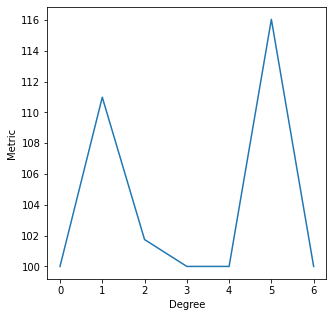

In [ ]:
# best metric is 99, which is not a good estimate + the model is fluctuating
plt.figure(figsize=(5, 5))
plt.xlabel('Degree')
plt.ylabel('Metric')
display(plt.plot(metrics_lr))

### HuberRegressor (metric - 44.87)

In [ ]:
from sklearn.linear_model import HuberRegressor
# define the model
model = HuberRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(f"Metric for HuberRegressor is: {metric(y_test, y_pred)}")

Metric for HuberRegressor is: 44.874099343379456


### Decision Tree (metric - 38.33)

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 42) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(f"Metric for DecisionTree is: {metric(y_test, y_pred)}")

Metric for DecisionTree is: 38.330733271472106


### Decision Tree GridSearch

In [ ]:
parameters={"splitter":["best","random"],
            "max_depth" : [x for x in range(10,31,5)],
           "min_samples_leaf":[3,4,5,6,7],
           #"min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt"],
           "max_leaf_nodes":[None,30,50,70,80,90] }

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
reg_decision_model=DecisionTreeRegressor()
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)

In [ ]:
tuning_model.fit(X_train,y_train)

In [146]:
# I didn't manage to run it on bigger and more complex trees (which would definitely help) + PCA might avoid dimentionality bias
best_params = tuning_model.best_params_
print(f'Best_params: {best_params}')

tree_reg = DecisionTreeRegressor(**best_params)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)
metric(y_test, y_pred)

Best_params: {'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 7, 'splitter': 'random'}


43.10122450074778